## Import the necessary libraries

In [1]:
import pandas as pd
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
%matplotlib inline

## Load data

In [2]:
# Load data
df = pd.read_csv('AZN-AstraZeneca.csv')

## Data preprocessing

In [3]:
# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Set the 'Date' column as the index value
df.set_index('Date', inplace=True)
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-03-01,41.610001,41.759998,41.480000,41.759998,36.845528,4590000
2019-03-04,41.730000,41.810001,41.389999,41.689999,36.783760,3948200
2019-03-05,41.560001,42.610001,41.560001,42.310001,37.330803,5668200
2019-03-06,42.360001,42.389999,41.930000,42.029999,37.083748,2490000
2019-03-07,41.610001,41.770000,41.330002,41.660000,36.757298,5283900
...,...,...,...,...,...,...
2024-02-23,64.959999,65.930000,64.949997,65.830002,65.830002,7388200
2024-02-26,66.080002,66.370003,65.750000,65.930000,65.930000,4597900
2024-02-27,65.940002,66.459999,65.769997,66.330002,66.330002,4433500


## Scale Data

In [4]:
# Select 'Close' column
data = df['Close'].values

In [5]:
# Scale data
scaler = MinMaxScaler(feature_range=(0,1))
data_scaled = scaler.fit_transform(data.reshape(-1, 1))

## Split the data into train and test

In [6]:
# Define the size of train and test
train_size = int(len(data_scaled) * 0.8)
test_size = len(data_scaled) - train_size

# Split the data into train and test set
train_data = data_scaled[0 : train_size, :]
test_data = data_scaled[train_size : len(data_scaled), :]

## Create and add data into X, y

In [7]:
def add_data(data, sequence_length=1):
    X, Y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i : (i + sequence_length), 0])
        Y.append(data[i + sequence_length, 0])
    return np.array(X), np.array(Y)

In [8]:
# Reshape into X=t,t+1,t+2..t+60 and Y=t+60
sequence_length = 60

# Get last data for test
train_last_windowsize = train_data[-sequence_length:]

test_data_extended = np.concatenate((train_last_windowsize, test_data), axis=0)

X_train, y_train = add_data(train_data, sequence_length)
X_test, y_test = add_data(test_data_extended, sequence_length)

# Reshape inputs to [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

## Build Model

In [9]:
model = Sequential() # Encapsulate the sequence of the inner layers

# 4 LSTM layers
model.add(LSTM(units = 50, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(units = 50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units = 50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))

# 1 Dense layer
model.add(Dense(units=1)) 

# Optimizer
model.compile(optimizer = 'adam', loss='mean_squared_error')

D:\Anaconda\Anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


## Training Model

In [10]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=2)

Epoch 1/50
30/30 - 36s - 1s/step - loss: 0.0434
Epoch 2/50
30/30 - 4s - 126ms/step - loss: 0.0105
Epoch 3/50
30/30 - 4s - 123ms/step - loss: 0.0075
Epoch 4/50
30/30 - 4s - 128ms/step - loss: 0.0072
Epoch 5/50
30/30 - 4s - 125ms/step - loss: 0.0069
Epoch 6/50
30/30 - 4s - 135ms/step - loss: 0.0072
Epoch 7/50
30/30 - 3s - 115ms/step - loss: 0.0063
Epoch 8/50
30/30 - 3s - 110ms/step - loss: 0.0061
Epoch 9/50
30/30 - 6s - 185ms/step - loss: 0.0058
Epoch 10/50
30/30 - 4s - 136ms/step - loss: 0.0061
Epoch 11/50
30/30 - 4s - 142ms/step - loss: 0.0056
Epoch 12/50
30/30 - 5s - 160ms/step - loss: 0.0052
Epoch 13/50
30/30 - 4s - 120ms/step - loss: 0.0059
Epoch 14/50
30/30 - 4s - 123ms/step - loss: 0.0047
Epoch 15/50
30/30 - 4s - 122ms/step - loss: 0.0051
Epoch 16/50
30/30 - 5s - 166ms/step - loss: 0.0050
Epoch 17/50
30/30 - 3s - 113ms/step - loss: 0.0052
Epoch 18/50
30/30 - 3s - 113ms/step - loss: 0.0050
Epoch 19/50
30/30 - 4s - 118ms/step - loss: 0.0042
Epoch 20/50
30/30 - 3s - 105ms/step - loss

## Predict and Inverse Transform the Predictions

In [11]:
y_pred = model.predict(X_test)

# Inverse transform the predictions
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
train_data = scaler.inverse_transform(train_data)
test_data = scaler.inverse_transform(test_data)

8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 556ms/step


## Calculate the error of the model

In [12]:
# The error in test set
test_mape = mean_absolute_percentage_error(y_pred, y_test)
test_mse = mean_squared_error(y_test, y_pred)
test_rmse = np.sqrt(test_mse)
test_msle = mean_squared_log_error(y_test, y_pred)

print(f"MAPE on Test set: ", test_mape)
print(f"RMSE on Test set: ", test_rmse)
print(f"MSLE on Test set: ", test_msle)

MAPE on Test set:  0.018094152444102642
RMSE on Test set:  1.5167344568245842
MSLE on Test set:  0.0004735571268494047


## Predict Close price for 90 next days

In [13]:
# Select the last day of current index
last_date = df.index[-1]

# Add a new day after the last day
next_date = last_date + pd.DateOffset(days=1)

# Generate a list of index only starting from the next day in 90 days
index_next_90_days = pd.date_range(start=next_date, periods=90).tolist()

# Predict Close price for 90 next days
last_sequence_days = data_scaled[-sequence_length:].reshape(1, -1, 1)

y_next_90_days = []

for i in range(90):
    # Predict Close price for next day
    next_day_pred = model.predict(last_sequence_days)
    
    # Save the predict value
    y_next_90_days.append(next_day_pred[0][0])
    
    # Update information of the next day
    last_sequence_days = np.concatenate([last_sequence_days[:, 1:, :], next_day_pred.reshape(1, 1, 1)], axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/ste

In [14]:
# Show the result of predict 90 next days 
y_next_90_days = scaler.inverse_transform(np.array(y_next_90_days).reshape(-1, 1))
print(y_next_90_days.flatten())

[64.803444 64.287025 63.83555  63.48392  63.222534 63.033466 62.901787
 62.815254 62.761993 62.729782 62.706722 62.682457 62.649128 62.601814
 62.538418 62.45932  62.36672  62.264027 62.155163 62.04406  61.934185
 61.828266 61.72818  61.634933 61.548733 61.469162 61.395336 61.326145
 61.260376 61.196877 61.134647 61.072914 61.011166 60.949112 60.8867
 60.824036 60.761345 60.69889  60.636986 60.5759   60.515865 60.457043
 60.399544 60.343388 60.288536 60.23494  60.18254  60.13121  60.08084
 60.031326 59.982594 59.93456  59.887173 59.840416 59.794285 59.748775
 59.703873 59.659603 59.61597  59.57301  59.530712 59.48907  59.448093
 59.407776 59.3681   59.32906  59.290623 59.25278  59.215527 59.178825
 59.142673 59.10705  59.07195  59.037357 59.00327  58.969673 58.93656
 58.903934 58.871777 58.840084 58.808853 58.77808  58.74775  58.717865
 58.6884   58.65937  58.630756 58.60255  58.57474  58.547337]


## Model visualization

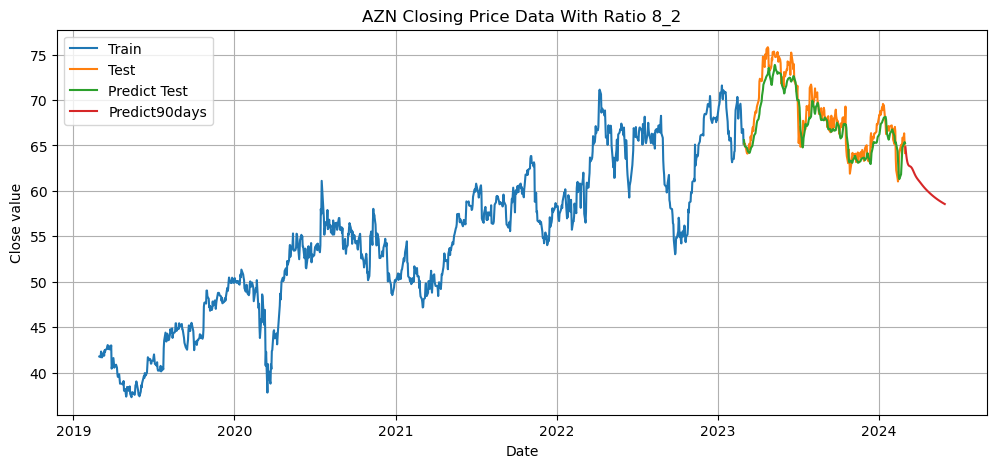

In [15]:
plt.figure(figsize=(12, 5))

# Train set
plt.plot(df[:train_size].index, train_data)

# Test set
plt.plot(df[train_size:].index, test_data)

# Predict in test set
plt.plot(df[train_size:].index, y_pred)

# Predict 90 next days
plt.plot(index_next_90_days, y_next_90_days)

plt.legend(['Train', 'Test', 'Predict Test', 'Predict90days'])
plt.grid()
plt.title("AZN Closing Price Data With Ratio 8_2")
plt.xlabel("Date")
plt.ylabel("Close value")
plt.savefig('Image/RNN_82_90days_AZN.png')
plt.show()